# 基础模型的构建和实验

## Import libraries

In [15]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import numpy as np
import random
import pandas as pd
import Model.Normal_Net as NN


seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## Generate data

tensor([ 0.7645,  0.8300, -0.2343,  0.9186, -0.2191,  0.2018, -0.4869,  0.5873,
         0.8815, -0.7336])
tensor([ 0.8692,  0.1872,  0.7388,  0.1354,  0.4822, -0.1412,  0.7709,  0.1478,
        -0.4668,  0.2549])
tensor([ 0.7645,  0.8300, -0.2343,  0.9186, -0.2191,  0.2018, -0.4869,  0.5873,
         0.8815, -0.7336])
tensor([ 0.8692,  0.1872,  0.7388,  0.1354,  0.4822, -0.1412,  0.7709,  0.1478,
        -0.4668,  0.2549])
tensor([ 0.7645,  0.8300, -0.2343,  0.9186, -0.2191,  0.2018, -0.4869,  0.5873,
         0.8815, -0.7336])
tensor([ 0.8692,  0.1872,  0.7388,  0.1354,  0.4822, -0.1412,  0.7709,  0.1478,
        -0.4668,  0.2549])


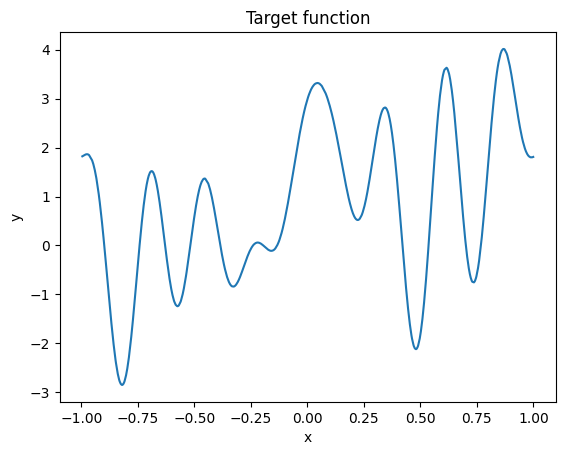

In [16]:

complexity = 10

def shuffle_data(examples):
    indices = torch.randperm(examples[0].size(0))
    shuffled_data = examples[0][indices]
    shuffled_labels = examples[1][indices]
    return shuffled_data, shuffled_labels

def round_tensor(tensor, decimal_places):
    factor = 10 ** decimal_places
    rounded_tensor = torch.round(tensor * factor) / factor
    return rounded_tensor

def targetfunc(x):
    torch.manual_seed(seed)
    random_tensor_1= 2 * torch.rand(complexity) - 1
    print(random_tensor_1)
    random_tensor_2= 2 * torch.rand(complexity) - 1
    print(random_tensor_2)
    
    y = 0

    for i, coef1 in enumerate(random_tensor_1):
        y += coef1 * torch.sin(i * torch.pi * x) + random_tensor_2[i] * torch.cos(i * torch.pi * x)
    return y

num_train = 2000
x_train = 2 * torch.rand(num_train, 1) - 1
y_train = targetfunc(x_train)
examples = (x_train, y_train)

num_val = 1000
x_val = 2 * torch.rand(num_val, 1) - 1
x_val, _ = torch.sort(x_val, dim=0)
y_val = targetfunc(x_val)
val_set = (x_val, y_val)

x_mesh = 2 * torch.linspace(0, 1 ,20) - 1
y_mesh = targetfunc(x_mesh)
test_mesh = (x_mesh, y_mesh)

plt.plot(val_set[0], val_set[1])
plt.title("Target function")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
examples = shuffle_data(examples)

## Results visualizetion functions

In [17]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def plot_3d_surface(x_val, num_epochs, errors):
    iters = np.arange(1, num_epochs + 1)
    x_val = x_val.squeeze().detach().numpy()
    errors = errors.squeeze().detach().numpy()
    
    fig = go.Figure(data=[go.Surface(
        x=iters,
        y=x_val,
        z=errors,
        colorscale='Viridis',  # 颜色映射，可以根据需要更改
        cmin=0,  # 最小值
        cmax=1  # 最大值
    )])
    fig.update_layout(
        scene=dict(
            xaxis_title='x_val',
            yaxis_title='iters',
            zaxis_title='Errors'
        ),
        width=800,
        height=600
    )
    fig.show()


def plot_animatin(x_val, num_epochs, images, fixed_function):
    # 检查输入是否为 PyTorch 张量，如果是则转换为 NumPy 数组
    if torch.is_tensor(x_val):
        x_val = x_val.numpy()
    if torch.is_tensor(images):
        images = images.numpy()
    if torch.is_tensor(fixed_function):
        fixed_function = fixed_function.numpy()

    # 对输入转置以匹配后续操作
    images = images.T
    # 检验形状是否正确
    num_val = x_val.size
    if images.shape != (num_epochs, num_val):
        raise Exception(f"Get image size = {images.shape}, which is not equal to ({num_epochs}, {num_val})")

    x_val = x_val.flatten()  # 形状 (num_val,)

    # 创建画布和初始曲线
    fig, ax = plt.subplots()
    line, = ax.plot(x_val, images[0], lw=1.5, label='Fixed Function')  # 初始动态曲线
    fixed_line, = ax.plot(x_val, fixed_function, lw=1.5, color='orange', label='Original Function')  # 固定函数曲线
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Fixing process of neural network')
    ax.set_xlim(x_val.min(), x_val.max())  # 设置 x 轴范围
    ax.set_ylim(-2, 2)  # 设置 y 轴范围
    ax.legend()  # 显示图例

    # 更新函数，用于每一帧的更新
    def update(frame):
        line.set_ydata(images[frame])  # 更新动态曲线的 y 值
        ax.set_title(f'Epoch: {frame + 1}/{num_epochs}')  # 更新标题
        return [line, fixed_line]

    # 创建动画
    ani = FuncAnimation(fig, update, frames=num_epochs, interval=100, blit=True)

    # 清除当前图形以避免额外输出
    plt.close(fig)

    # 在 Jupyter Notebook 中显示动画
    return HTML(ani.to_jshtml())

# 用于可视化测试结果和原函数的对比 - 已弃用
def visualize_result(model, val_set):
    # 绘制直观的拟合图像
    outputs = model(val_set[0]).detach()
    # 现在可以绘制排序后的数据了
    plt.plot(val_set[0], val_set[1], label="Original function")
    plt.plot(val_set[0], outputs, label="Fitting result")
    plt.xlabel("X values")
    plt.ylabel("Y values")
    plt.legend()
    plt.show()


## Train on MSELoss(SGD) - Standerd

In [18]:
# 生成使用不同激活函数的模型们
activations = [nn.Tanh(), nn.LeakyReLU(negative_slope=0.1), nn.Softplus(), nn.ELU()]
# activations = [NN.CustomHardtanhLayer(), nn.LeakyReLU(negative_slope=0.1), nn.ReLU()]
models = [NN.NormNet(activation_func, 20, usebatchnorm=False, use_grad_norm=False, use_combination=False, gamma=0.2, take_rand=False) for activation_func in activations]

Initial model saved !

Result Tanh : 


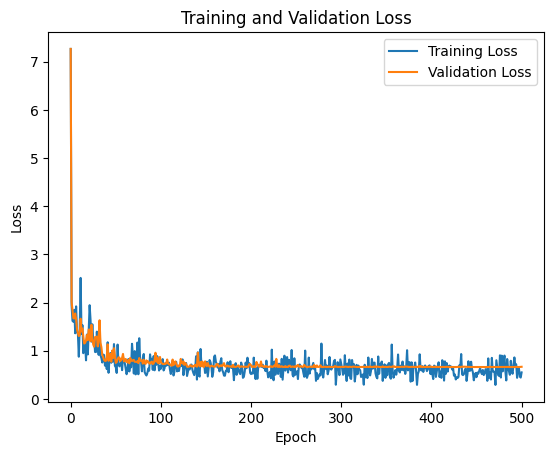

Finished Training


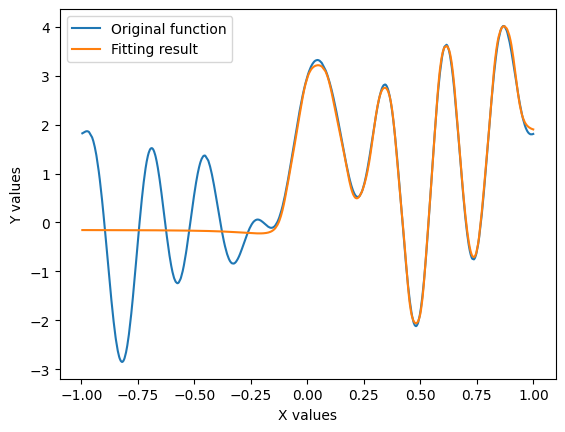

Initial model saved !

Result LeakyReLU : 


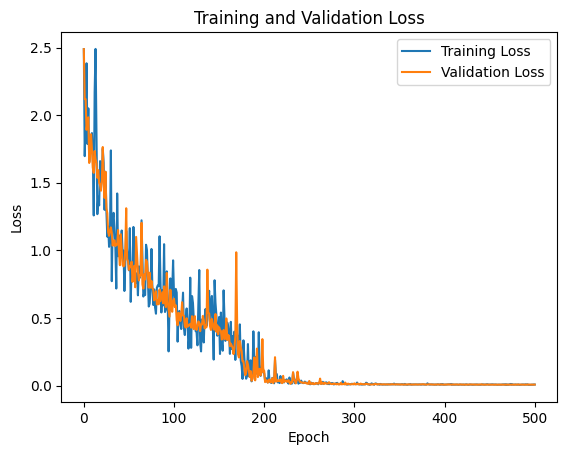

Finished Training


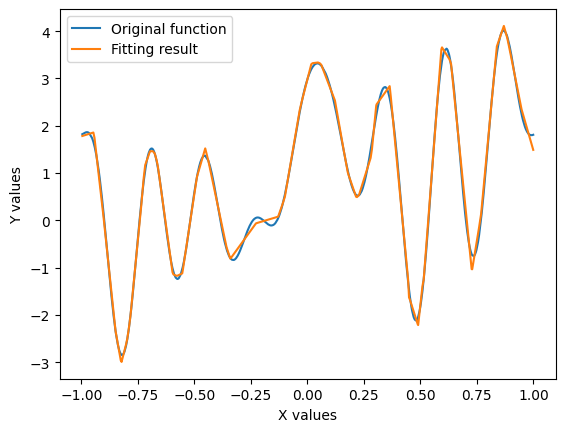

Initial model saved !

Result Softplus : 


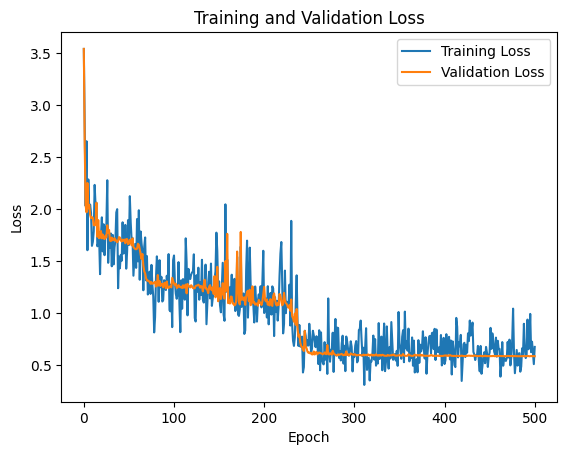

Finished Training


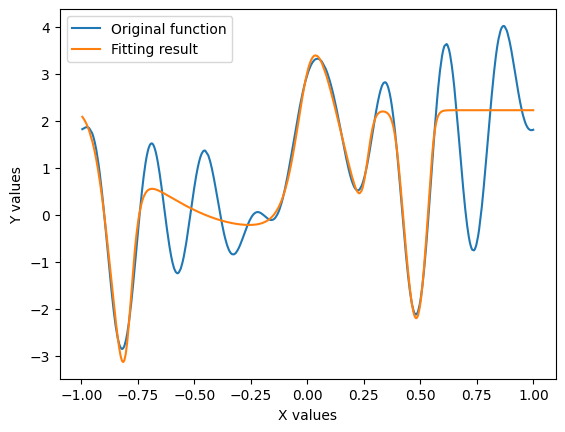

Initial model saved !

Result ELU : 


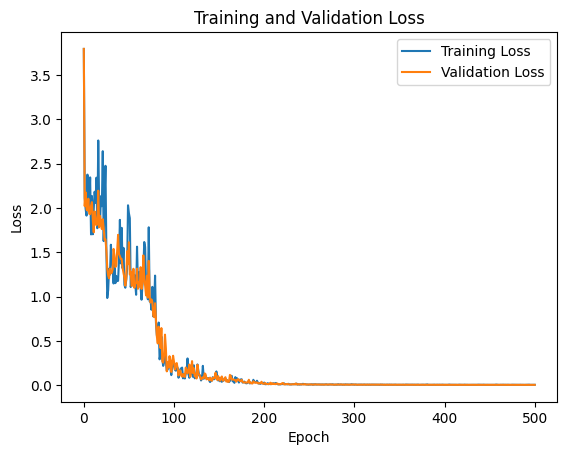

Finished Training


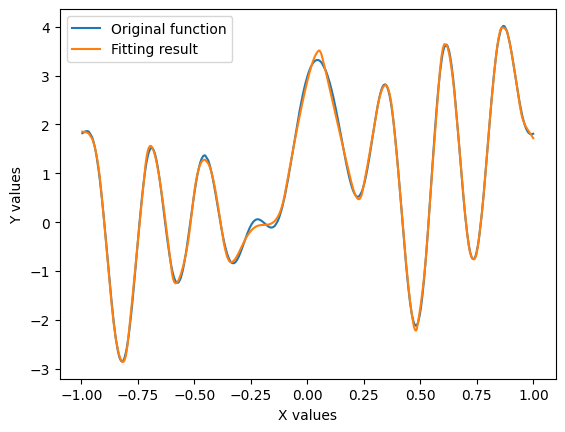

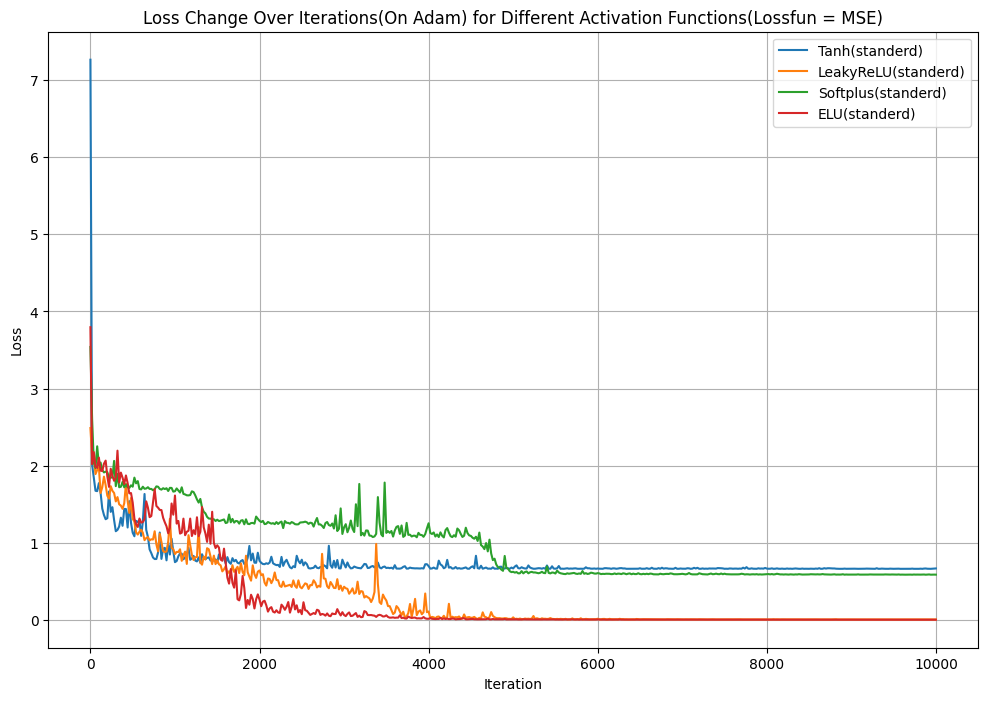

In [19]:
# 初始化模型、损失函数和优化器
criterion = nn.MSELoss()  # 均方误差损失
num_epochs = 10000
show_epoch = 500

losses_df = pd.DataFrame()
losses_df['Iteration'] = list(range(0, num_epochs + num_epochs//show_epoch, num_epochs//show_epoch))


for model in models:
    
    # 获取激活函数名称
    act_name = model.activation_func._get_name()

    # 重新初始化
    model.reset_parameters()
    # 储存模型
    torch.save(model.state_dict(), f'initial model(on {act_name}).pth')
    print("Initial model saved !\n")

    

    # # 分离参数组
    # batchnorm_params = []
    # other_params = []

    # for name, param in model.named_parameters():
    #     if 'batchnorm' in name:  # 假设 BatchNorm 层的参数名称中包含 'bn'
    #         batchnorm_params.append(param)
    #     else:
    #         other_params.append(param)

    # 定义优化器
    optimizer = NN.CustomSGD(model.parameters(), lr=0.1, momentum=0.9, clip_value=1)
    
    # # 定义优化器
    # optimizer = optim.SGD([
    #     {'params': batchnorm_params, 'lr': 0.001},
    #     {'params': other_params, 'lr': 0.02, 'momentum': 0.9}
    # ])
    # optimizers = [optimizer]

    # # 创建优化器
    # optimizer_bn = optim.SGD(batchnorm_params, lr=0.001, momentum=0.9)
    # optimizer_other = optim.Adam(other_params, lr=0.01)
    # optimizers = [optimizer_bn, optimizer_other]

    # 训练模型
    print("Result", model.activation_func._get_name(), ": ")
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.8)
    model, val_losses, errors, images = NN.train_normalnet(model, examples, val_set, criterion, optimizer, batch_size=100, num_epochs=num_epochs, show_epoch=show_epoch, print_info=False, scheduler=scheduler)

    # 绘制直观的拟合图像 - 已弃用
    visualize_result(model, val_set)

    # 绘制三维平面图
    # plot_3d_surface(x_val, num_epochs+1, errors)
    # plot_3d_surface(x_val, num_epochs+1, images)

    # # 绘制动画
    # ani = plot_animatin(x_val, show_epoch+1, images, y_val)
    # display(ani)

    # 制作训练过程中验证误差的datafram
    losses_df[act_name + "(standerd)"] = val_losses
    
    # # 构建神经网络激活图
    # val_loss = model.validation(val_set, criterion, True)
    

# 训练过程中验保存证误差的datafram
losses_df_1 = losses_df.reset_index(drop=True)


# 绘制验证集上的损失变化曲线
plt.figure(figsize=(12, 8))  # 设置图形大小
for col in losses_df_1.columns[1:]:  # 遍历除了'Iteration'之外的所有列（即激活函数的损失值）
    plt.plot(losses_df_1['Iteration'], losses_df_1[col], label=col)  # 绘制曲线

plt.xlabel('Iteration')  # X轴标签：迭代次数
plt.ylabel('Loss')  # Y轴标签：损失值
plt.title('Loss Change Over Iterations(On Adam) for Different Activation Functions(Lossfun = MSE)')  # 图形标题
plt.legend()  # 显示图例
plt.grid(True)  # 显示网格线
plt.show()  # 显示图形

## Train on MSELoss(SGD) - expiremental

Model loaded !



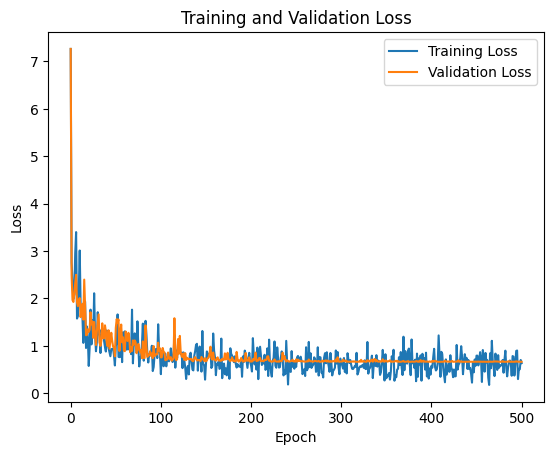

Finished Training
Result Tanh : 


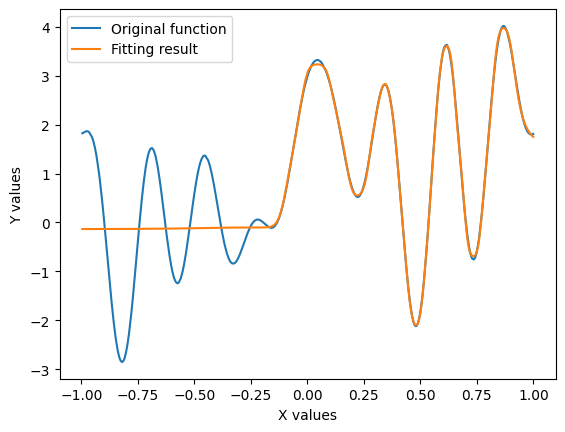

Model loaded !



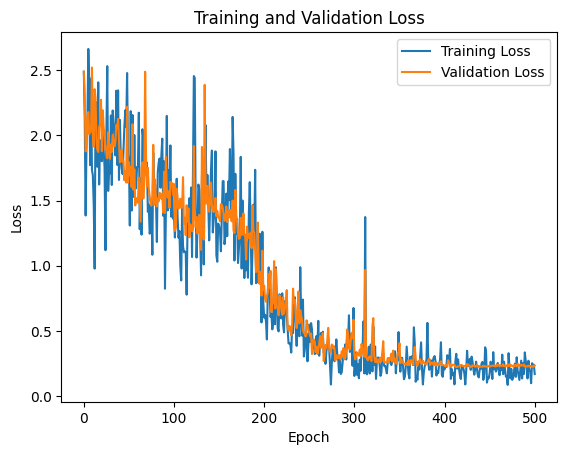

Finished Training
Result LeakyReLU : 


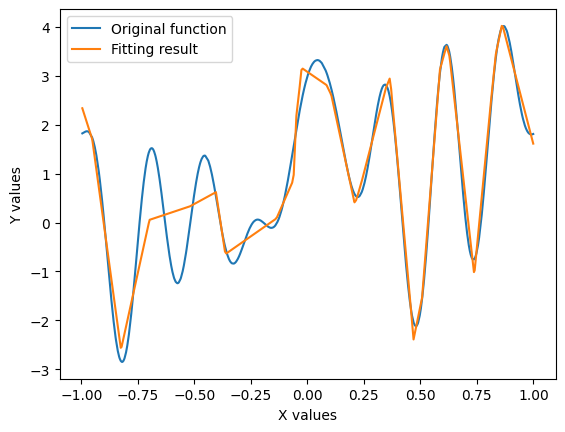

Model loaded !



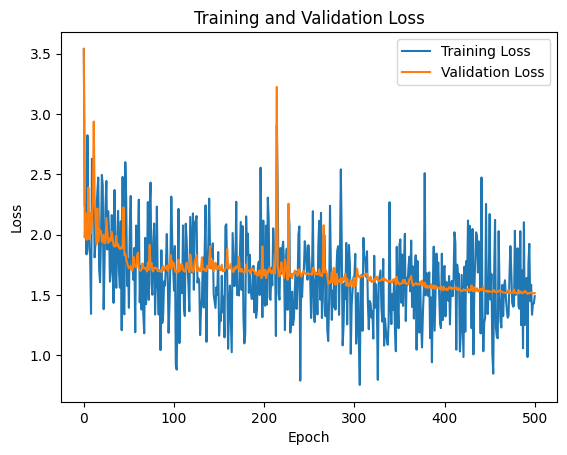

Finished Training
Result Softplus : 


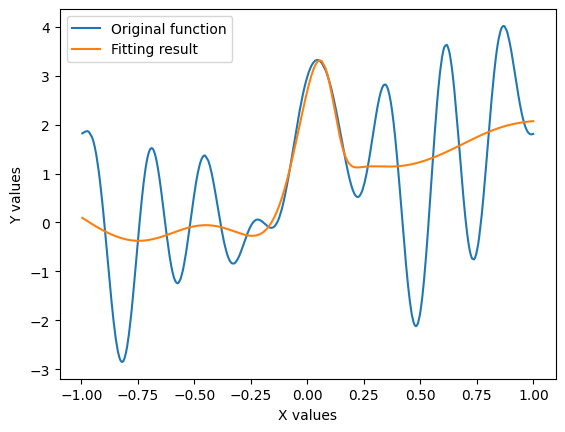

Model loaded !



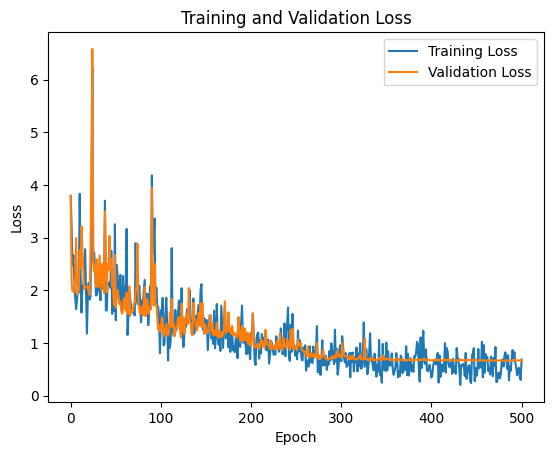

Finished Training
Result ELU : 


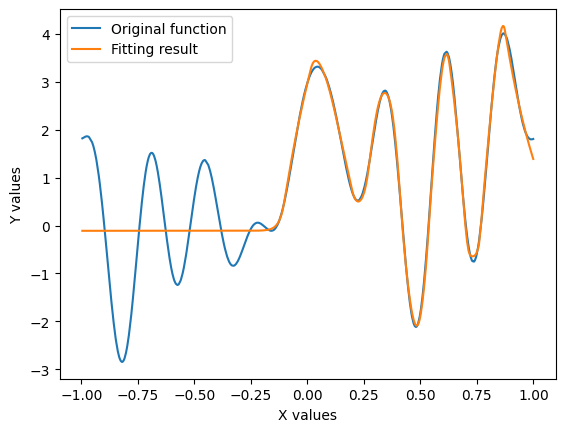

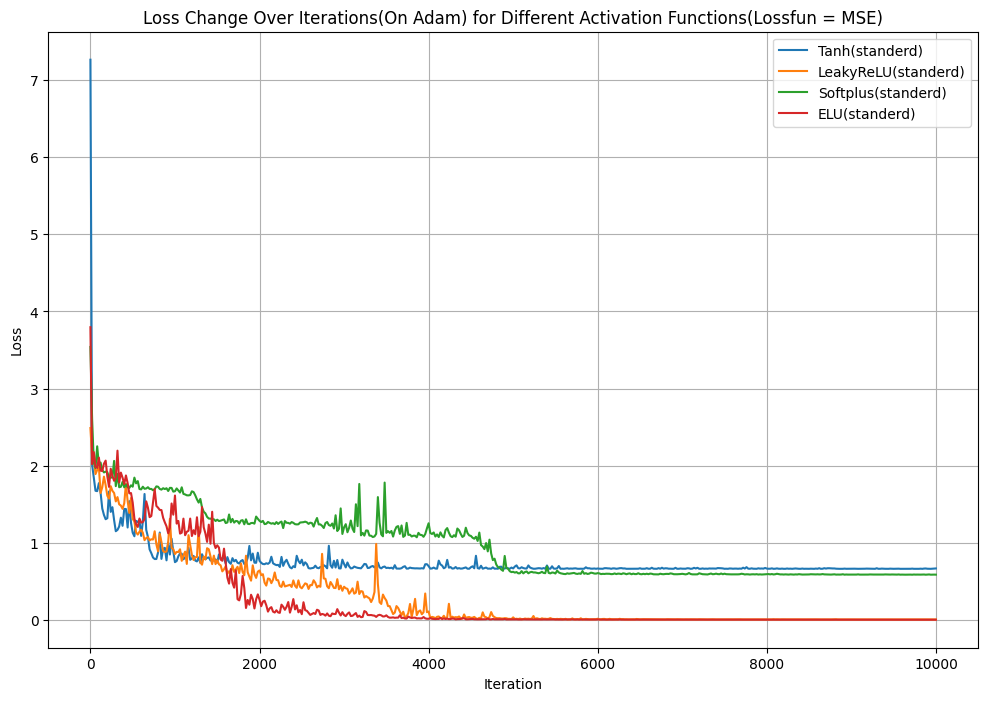

In [21]:
# 初始化模型、损失函数和优化器
criterion = nn.MSELoss()  # 均方误差损失
num_epochs = 10000
show_epoch = 500

losses_df = pd.DataFrame()
losses_df['Iteration'] = list(range(0, num_epochs + num_epochs//show_epoch, num_epochs//show_epoch))


for model in models:
    
    # 获取激活函数名称
    act_name = model.activation_func._get_name()
    
    # 加载模型
    model.load_state_dict(torch.load(f'initial model(on {act_name}).pth', weights_only=True))
    print("Model loaded !\n")
    

    # # 分离参数组
    # batchnorm_params = []
    # other_params = []

    # for name, param in model.named_parameters():
    #     if 'batchnorm' in name:  # 假设 BatchNorm 层的参数名称中包含 'bn'
    #         batchnorm_params.append(param)
    #     else:
    #         other_params.append(param)

    # 定义优化器
    # optimizer = optim.SGD(model.parameters(), lr=0.01)
    optimizer = NN.CustomSGD(model.parameters(), lr=0.1, momentum=0.9, clip_value=1)
    
    # # 定义优化器
    # optimizer = optim.SGD([
    #     {'params': batchnorm_params, 'lr': 0.001},
    #     {'params': other_params, 'lr': 0.02, 'momentum': 0.9}
    # ])
    # optimizers = [optimizer]

    # # 创建优化器
    # optimizer_bn = optim.SGD(batchnorm_params, lr=0.001, momentum=0.9)
    # optimizer_other = optim.Adam(other_params, lr=0.01)
    # optimizers = [optimizer_bn, optimizer_other]

    # 训练模型
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.8)
    model, val_losses, errors, images = NN.train_normalnet(model, examples, val_set, criterion, optimizer, batch_size=50, num_epochs=num_epochs, show_epoch=show_epoch, print_info=False, scheduler=scheduler)
    print("Result", model.activation_func._get_name(), ": ")

    # 绘制直观的拟合图像 - 已弃用
    visualize_result(model, val_set)

    # 绘制三维平面图
    # plot_3d_surface(x_val, num_epochs+1, errors)
    # plot_3d_surface(x_val, num_epochs+1, images)
    
    # # 绘制动画
    # ani = plot_animatin(x_val, show_epoch+1, images, y_val)
    # display(ani)

    # 制作训练过程中验证误差的datafram
    losses_df[act_name] = val_losses
    
    # # 构建神经网络激活图
    # val_loss = model.validation(val_set, criterion, True)

    # # 储存模型
    # torch.save(model.state_dict(), f'model(on {model.activation_func._get_name()}).pth')
    # print("Model saved !\n")

# 显示训练过程中验证误差的datafram 
losses_df = losses_df.reset_index(drop=True)

# 绘制验证集上的损失变化曲线
plt.figure(figsize=(12, 8))  # 设置图形大小
for col in losses_df_1.columns[1:]:  # 遍历除了'Iteration'之外的所有列（即激活函数的损失值）
    plt.plot(losses_df_1['Iteration'], losses_df_1[col], label=col)  # 绘制曲线

plt.xlabel('Iteration')  # X轴标签：迭代次数
plt.ylabel('Loss')  # Y轴标签：损失值
plt.title('Loss Change Over Iterations(On Adam) for Different Activation Functions(Lossfun = MSE)')  # 图形标题
plt.legend()  # 显示图例
plt.grid(True)  # 显示网格线
plt.show()  # 显示图形

结果显示

,Iteration,Tanh,LeakyReLU,Softplus,ELU
0,0,7.2633953,2.4882233,3.5394003,3.7954943
1,20,2.492018,2.3030117,1.9770615,2.1531098
2,40,1.9663835,1.8766502,2.1789076,1.9884064
3,60,1.925547,1.9053261,1.9571387,2.0440402
4,80,2.0953557,2.152745,1.9692352,1.9628648
...,...,...,...,...,...
496,9920,0.66808385,0.22673146,1.5205146,0.6696011
497,9940,0.66414964,0.22400755,1.5137256,0.6682692
498,9960,0.66370934,0.23046724,1.5133191,0.6666589
499,9980,0.6635436,0.22572504,1.5171802,0.6811262


,Iteration,Tanh(standerd),LeakyReLU(standerd),Softplus(standerd),ELU(standerd)
0,0,7.2633953,2.4882233,3.5394003,3.7954943
1,20,2.013054,2.1182196,2.6035175,2.0208602
2,40,1.8467621,2.1184342,2.0374694,2.1758578
3,60,1.6748241,1.8912188,1.9699411,1.9832696
4,80,1.6701018,1.9447967,2.2514472,1.9714831
...,...,...,...,...,...
496,9920,0.66297877,0.0063356436,0.5901791,0.0030973724
497,9940,0.6630268,0.0064185485,0.58695567,0.0031126621
498,9960,0.6649002,0.0064449767,0.5882084,0.0031587367
499,9980,0.6656834,0.006395153,0.5881548,0.003187549


Expirmental: 
Tanh         0.664688
LeakyReLU    0.228211
Softplus     1.516257
ELU           0.67058
dtype: object
Standerd: 
Tanh(standerd)         0.664909
LeakyReLU(standerd)    0.006461
Softplus(standerd)     0.588153
ELU(standerd)          0.003138
dtype: object


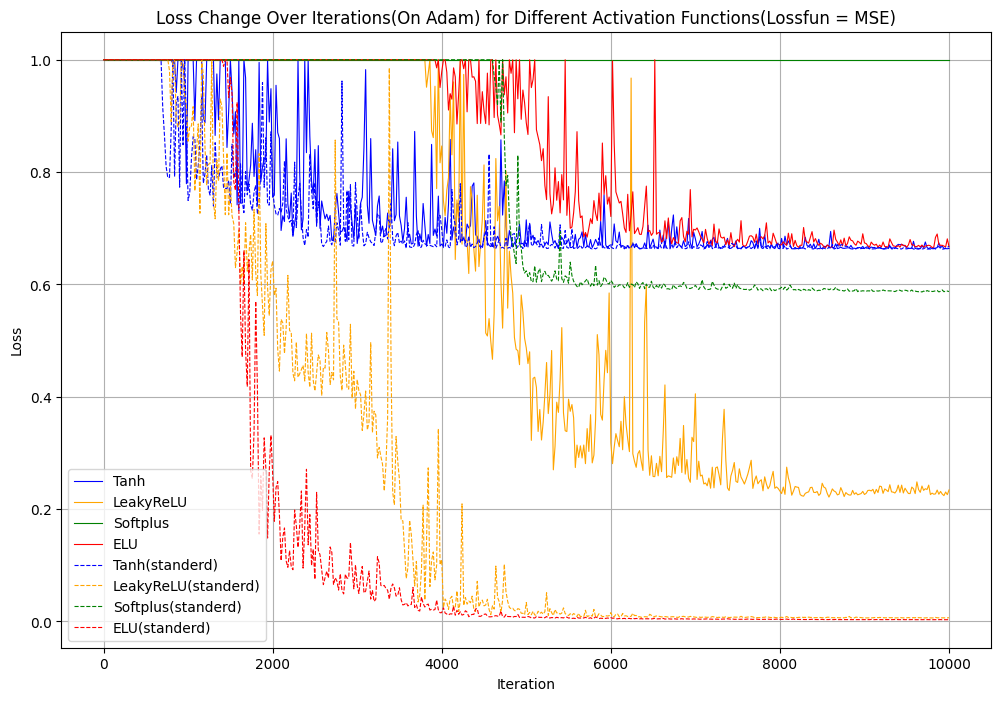

In [22]:
def show_avg_loss(df):
    column_names = list(df.columns)
    # 计算每列后 10 行的平均值，如果行数少于 10 行，则计算所有行的平均值
    last_10_avg = df[column_names[1:]].tail(5).mean()

    print(last_10_avg)


losses_df = losses_df
losses_df_1 = losses_df_1

# 显示训练过程中验证误差的datafram
display(losses_df)
display(losses_df_1)

colors = ['blue', 'orange', 'green', 'red', 'purple']
# 绘制验证集上的损失变化曲线
plt.figure(figsize=(12, 8))  # 设置图形大小
for i, col in enumerate(losses_df.columns[1:], start=0):  # 遍历除了'Iteration'之外的所有列（即激活函数的损失值）
    plt.plot(losses_df['Iteration'], losses_df[col].clip(upper=1), label=col, color=colors[i], linewidth=0.8)  # 绘制曲线

# 绘制验证集上的损失变化曲线(standerd)
for i, col in enumerate(losses_df_1.columns[1:], start=0):  # 遍历除了'Iteration'之外的所有列（即激活函数的损失值）
    plt.plot(losses_df_1['Iteration'], losses_df_1[col].clip(upper=1), label=col, linestyle='--', color=colors[i], linewidth=0.8)  # 绘制曲线

print("Expirmental: ")
show_avg_loss(losses_df)
print("Standerd: ")
show_avg_loss(losses_df_1)

plt.xlabel('Iteration')  # X轴标签：迭代次数
plt.ylabel('Loss')  # Y轴标签：损失值
plt.title('Loss Change Over Iterations(On Adam) for Different Activation Functions(Lossfun = MSE)')  # 图形标题
plt.legend()  # 显示图例
plt.grid(True)  # 显示网格线
plt.show()  # 显示图形

# Trushbin

In [23]:
# activations = [nn.Sigmoid(), nn.Tanh(), nn.ReLU(), nn.LeakyReLU(negative_slope=0.1), nn.Softplus(), nn.ELU()]
# models = [NormNet(activation_func) for activation_func in activations]

# num_epochs = 10000
# show_epoch = 100
# # 初始化模型、损失函数和优化器
# criterion = nn.MSELoss()  # 均方误差损失
# # criterion = nn.L1Loss()

# losses_df = pd.DataFrame()
# losses_df['Iteration'] = list(range(show_epoch, num_epochs + show_epoch, show_epoch))


# for model in models:

#     optimizer = optim.SGD(model.parameters(), lr=0.008)
#     # 训练模型
#     model, val_losses, _ = train_normalnet(model, examples, val_set, criterion, optimizer, num_epochs=num_epochs, show_epoch=show_epoch)

#     # 绘制直观的拟合图像
#     outputs = model(x_val).detach()
#     # 使用 zip 将它们组合成一个列表的元组，然后根据 x_val 的值进行排序
#     sorted_data = sorted(zip(x_val, y_val, outputs), key=lambda x: x[0])

#     # 解压排序后的数据
#     sorted_x_val, sorted_y_val, sorted_outputs = zip(*sorted_data)

#     # 现在可以绘制排序后的数据了
#     plt.plot(sorted_x_val, sorted_y_val, label="Original function")
#     plt.plot(sorted_x_val, sorted_outputs, label="Fitting result")
#     plt.xlabel("X values")
#     plt.ylabel("Y values")
#     plt.legend()
#     plt.show()

    
    
#     losses_df[model.activation_func._get_name()] = val_losses
    
# losses_df = losses_df.reset_index(drop=True)
# display(losses_df)

# # 绘制损失变化曲线
# plt.figure(figsize=(12, 8))  # 设置图形大小
# for col in losses_df.columns[1:]:  # 遍历除了'Iteration'之外的所有列（即激活函数的损失值）
#     plt.plot(losses_df['Iteration'], losses_df[col], label=col)  # 绘制曲线

# plt.xlabel('Iteration')  # X轴标签：迭代次数
# plt.ylabel('Loss')  # Y轴标签：损失值
# plt.title('Loss Change Over Iterations(On Adam) for Different Activation Functions(Lossfun = MSE)')  # 图形标题
# plt.legend()  # 显示图例
# plt.grid(True)  # 显示网格线
# plt.show()  # 显示图形

In [24]:
# bias = 0
# x = torch.tensor([[0],[1]])
# print(x.size())
# print(x)
# x_with_bias = torch.cat([torch.ones(x.size(0), bias, device=x.device), x], dim=1)
# print(x_with_bias)
# print(x.dim())


# # 自定义线性层
# class CustomLinear(nn.Module):
#     def __init__(self, input_dim, output_dim, bias=1):
#         super().__init__()
#         self.bias = bias
#         self.weight = nn.Parameter(torch.Tensor(output_dim, input_dim + self.bias))  # 权重矩阵包含偏置项
#         nn.init.xavier_uniform_(self.weight)  # 初始化权重

#     def forward(self, x):
#         # 输入 x 的形状: (batch_size, input_dim)
#         # 添加全 1 列（偏置项）
#         x_with_bias = torch.cat([torch.ones(x.size(0),self.bias, device=x.device), x], dim=1)
#         # 计算输出: (batch_size, output_dim)
#         return torch.mm(x_with_bias, self.weight.t())

In [25]:
# plt.scatter(x_train[:100], y_train[:100])
# plt.show()
# plt.scatter(x_train[100:200], y_train[100:200])
# plt.show()

## Additions

In [26]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 定义每个激活函数及其对应的导数
# def sigmoid(x):
#     return 1 / (1 + np.exp(-x))

# def tanh(x):
#     return np.tanh(x)

# def leakyrelu(x, alpha=0.01):
#     return np.maximum(alpha * x, x)

# def softplus(x):
#     return np.log(1 + np.exp(x))

# def elu(x, alpha=0.1):
#     return np.where(x > 0, x, alpha * (np.exp(x) - 1))

# # 定义一阶导数
# def sigmoid_derivative(x):
#     s = sigmoid(x)
#     return s * (1 - s)

# def tanh_derivative(x):
#     return 1 - np.tanh(x)**2

# def leakyrelu_derivative(x, alpha=0.01):
#     grad = np.ones_like(x)
#     grad[x <= 0] = alpha
#     return grad

# def softplus_derivative(x):
#     s = sigmoid(x)
#     return s * (1 - s)

# def elu_derivative(x, alpha=0.1):
#     grad = np.zeros_like(x)
#     grad[x > 0] = 1
#     grad[x <= 0] = alpha * np.exp(x[x <= 0])
#     return grad

# # 定义二阶导数
# def sigmoid_second_derivative(x):
#     s = sigmoid_derivative(x)
#     return (np.exp(-x) - np.exp(x)) / (np.exp(x) + np.exp(-x) + 2)**2

# def tanh_second_derivative(x):
#     td = tanh_derivative(x)
#     return -2 * np.tanh(x) * (1 - np.tanh(x)**2)

# def leakyrelu_second_derivative(x, alpha=0.01):
#     return 0.0 * x  # LeakyReLU的二阶导数在x>0时为0，在x<0时也为0（因为一阶导数是常数）

# def softplus_second_derivative(x):
#     s = softplus_derivative(x)
#     return s - s**2

# def elu_second_derivative(x, alpha=0.1):
#     sd = np.zeros_like(x)
#     sd[x <= 0] = alpha * np.exp(x[x <= 0])
#     return sd

# # 创建x值
# x = np.linspace(-5, 5, 1000)

# # 绘制每个激活函数及其导数的图像
# functions = [
#     (sigmoid, sigmoid_derivative, sigmoid_second_derivative),
#     (tanh, tanh_derivative, tanh_second_derivative),
#     (lambda x: leakyrelu(x), lambda x: leakyrelu_derivative(x), lambda x: leakyrelu_second_derivative(x)),
#     (softplus, softplus_derivative, softplus_second_derivative),
#     (lambda x: elu(x), lambda x: elu_derivative(x), lambda x: elu_second_derivative(x))
# ]

# titles = ['Sigmoid', 'Tanh', 'LeakyReLU', 'Softplus', 'ELU']

# plt.figure(figsize=(15, 9))

# for i in range(len(functions)):
#     # 创建子图
#     plt.subplot(3, len(functions), i + 1)
#     f, f_prime, f_double_prime = functions[i]
    
#     y = f(x)
#     y_prime = f_prime(x)
#     y_double_prime = f_double_prime(x)
    
#     plt.plot(x, y, label='Function')
#     plt.plot(x, y_prime, '--', label='First Derivative')
#     plt.plot(x, y_double_prime, ':', label='Second Derivative')
    
#     plt.title(titles[i])
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.grid(True)
#     plt.legend()

# plt.tight_layout()
# plt.show()

In [27]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sympy import symbols, exp, diff, lambdify

# x = symbols('x')
# sigmoid = 1 / (1 + exp(-x))

# # 计算1-5阶导数
# derivatives = [diff(sigmoid, x, n) for n in range(1, 10)]
# funcs = [lambdify(x, d, "numpy") for d in derivatives]

# # 绘图
# x_vals = np.linspace(-3, 3, 1000)
# plt.figure(figsize=(12, 8))

# for i, func in enumerate(funcs):
#     y_vals = func(x_vals)
#     plt.plot(x_vals, y_vals, label=f'{i+1} step derivative')

# plt.title("The first 5th derivative of the Sigmoid function", fontsize=14)
# plt.xlabel("x", fontsize=12)
# plt.ylabel("Amplitude of derivative", fontsize=12)
# plt.grid(linestyle='--', alpha=0.5)
# plt.legend()
# plt.xlim(-3, 3)
# plt.show()

In [28]:
if torch.randint(0, 3, (1,)) < 1:
    print("ok")

print(0.08*0.7**20)

ok
6.383381303808951e-05
